# Preferences

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchsummary import summary
from torchviz import make_dot
print(torch.__version__)

import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from IPython.display import Image

2.3.1


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("Available GPUs:", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPUs available, CPU {} ".format(device))

Available GPUs: 1
GPU 0: NVIDIA GeForce GTX 1080


# Data Preprocessing

def my_DataLoader(train_root,test_root,batch_size = 100, val_split_factor = 0.2):

    train_df = pd.read_csv(train_root, header=None)
    test_df = pd.read_csv(test_root, header=None)

    train_data = train_df.to_numpy()
    test_data = test_df.to_numpy()

    train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_data[:, :-1]).float(),
                                                   torch.from_numpy(train_data[:, -1]).long(),)
    test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_data[:, :-1]).float(),
                                                  torch.from_numpy(test_data[:, -1]).long())

    train_len = train_data.shape[0]
    val_len = int(train_len * val_split_factor)
    train_len -= val_len

    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_len, val_len])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

In [3]:
train_pd = pd.read_csv("/home/hanaesori/workspace/jupyter_notebook/Neural_Network/csv/mitbih_train.csv", header=None)
train_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train_np = train_pd.to_numpy()
train_data = torch.utils.data.TensorDataset(torch.from_numpy(train_np[:, :-1]).float(), torch.from_numpy(train_np[:, -1]).long(),)
train_loader = DataLoader(train_data, batch_size=1000, shuffle=True)

X_train = train_data.tensors[0]
Y_train = train_data.tensors[1]

print('Data Set(Sample, Features) :', len(train_data), X_train.shape[1]) #=> X shape : (87553, 187)
print('Number of Categories :', len(Y_train.unique()))
print('Classes[Normal = 0, Supra-ventricular = 1, Ventricular escape = 2, Fusion of ventricular = 3, Unclassifiable = 4] :')
for i in range(len(Y_train.unique())):
    print(f'Label {Y_train.unique()[i].item()} count: {torch.sum(Y_train == Y_train.unique()[i])}')

Data Set(Sample, Features) : 87554 187
Number of Categories : 5
Classes[Normal = 0, Supra-ventricular = 1, Ventricular escape = 2, Fusion of ventricular = 3, Unclassifiable = 4] :
Label 0 count: 72471
Label 1 count: 2223
Label 2 count: 5788
Label 3 count: 641
Label 4 count: 6431


In [5]:
val_split_factor = 0.2
batch_size = 100

train_len = train_np.shape[0]
val_len = int(train_len * val_split_factor)
train_len -= val_len

train_data, val_data = torch.utils.data.random_split(train_data, [train_len, val_len])
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=7, stratify=Y)
print('Train shape :',x_train.shape) #=> Train shape : (3998, 140)
print('Test shape :',x_test.shape) #=> Test shape : (1000, 140)

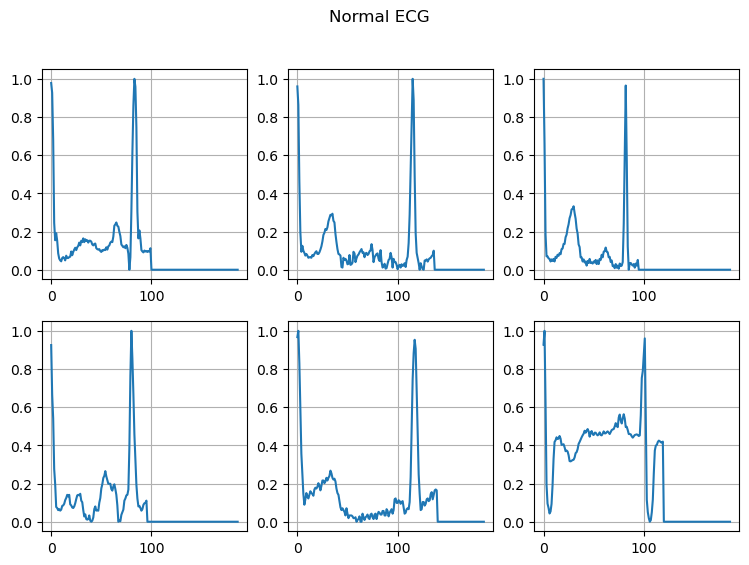

In [6]:
normal_X_train = X_train[Y_train == 0]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(9,6))
fig.suptitle("Normal ECG")
ax = ax.ravel()
for idx, ax in enumerate(ax):
    ax.grid()
    ax.plot(np.arange(len(normal_X_train[idx])), normal_X_train[idx])
plt.show()

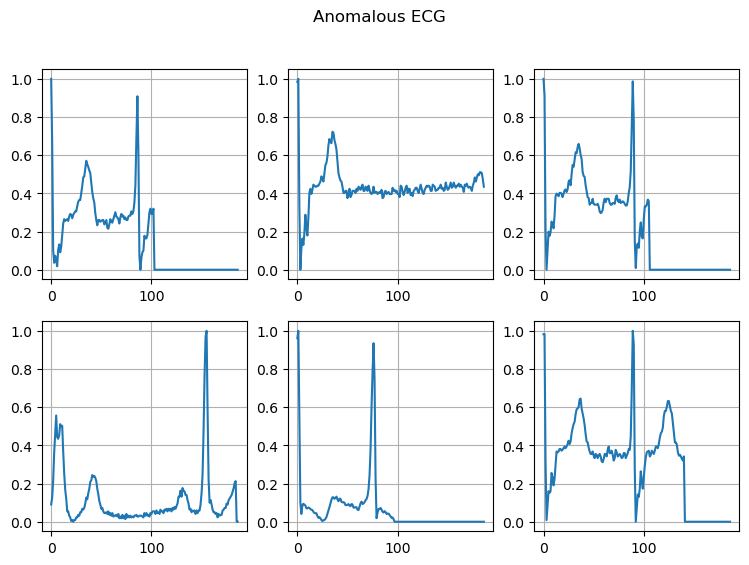

In [7]:
anomalous_X_train = X_train[Y_train!=0]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(9,6))
fig.suptitle("Anomalous ECG")
ax = ax.ravel()
for idx, ax in enumerate(ax):
    ax.grid()
    ax.plot(np.arange(len(anomalous_X_train[idx])), anomalous_X_train[idx])
plt.show()

# LSTM Modeling

In [8]:
class ConvBlock(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.intro_bn = nn.BatchNorm1d(32)
    
        self.C11 = nn.Conv1d(32, 32, kernel_size=5, padding=2)
        self.A11 = nn.ReLU()
        self.C12 = nn.Conv1d(32, 32, kernel_size=5, padding=2)
        self.A12 = nn.ReLU()
        self.M11 = nn.MaxPool1d(kernel_size=5, stride=2)

    def forward(self, x):
        x = self.intro_bn(x)
        C = x
        x = self.C11(x)
        x = self.A11(x)
        x = self.C12(x)
        x = x + C
        x = self.A12(x)
        x = self.M11(x)
        
        return x
    
class proposed(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_in = nn.Conv1d(1, 32, kernel_size=5)
        
        self.conv_blocks = nn.ModuleList(ConvBlock() for i in range(5))
        
        self.avg_pool = nn.AvgPool1d(2)
        self.fc1 = nn.Linear(32,32)
        self.acc1 = nn.ReLU()
        self.fc2 = nn.Linear(32,5)
        
    def forward(self, x):
        if x.dim() == 2:  # [batch_size, length]
            x = x.unsqueeze(1)
            
        x = self.conv_in(x)
        
        for i in range(5):
            x = self.conv_blocks[i](x)
        
        x = self.avg_pool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.acc1(x)
        x = self.fc2(x)
        
        return x

In [9]:
def evalute(model, loader, crit):
    model.eval()

    correct = 0
    total = len(loader.dataset)
    val_bar = tqdm(loader, file=sys.stdout)
    cur_loss=[]
    for x, y in val_bar:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            logits = model(x)
            pred = logits.argmax(dim=1)
            cur_loss.append(crit(logits, y))
        correct += torch.eq(pred, y).sum().float().item()

    return correct / total, sum(cur_loss)/len(cur_loss)

In [10]:
model = proposed().to(device)
compiled_model = torch.compile(model).cuda

# Model Learning

In [11]:
batch_size = 100
lr = 3e-3
epochs = 10
torch.manual_seed(1234)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [12]:
best_acc, best_epoch = 0, 0
global_step = 0
train_acc=[]
train_loss=[]
val_acc=[]
val_loss=[]
for epoch in range(epochs):
    correct=0
    train_bar = tqdm(train_loader, file=sys.stdout)
    for step, (x, y) in enumerate(train_bar):
        # x: [b, 187], y: [b]
        x, y = x.to(device), y.to(device)
        model.train()
        logits = model(x)
        loss = criterion(logits, y)
        preds=logits.argmax(dim=1)
        correct+=torch.eq(preds, y).sum().float().item()
        optimizer.zero_grad()
        loss.backward()
        
        # for param in model.parameters():
        #     print(param.grad)
        optimizer.step()
        
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                 epochs,
                                                                 loss)
        global_step += 1
    train_loss.append(loss)
    train_acc.append(correct/len(train_loader.dataset))
    print('Train Acc: {}'.format(correct/len(train_loader.dataset)))
    if epoch % 1 == 0:  # You can change the validation frequency as you wish
        val_acc_epo, val_loss_epo = evalute(model, val_loader, criterion)
        val_acc.append(val_acc_epo)
        val_loss.append(val_loss_epo)
        print('val_acc = ',val_acc_epo)
        if val_acc_epo > best_acc:
            best_epoch = epoch
            best_acc = val_acc_epo
            #torch.save(model, 'LSTM.pt')
            torch.save(model.state_dict(), 'LSTM.mdl')
            #torch.save(model.state_dict(), 'LSTM_weights.pt')
print('best acc:', best_acc, 'best epoch:', best_epoch)
model.load_state_dict(torch.load('LSTM.mdl'))
print('loaded from ckpt!')

  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9102154099184503


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9583666476299257


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9736848116590904


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9777841233580811


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9794069945405122


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9810965162764135


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9833017337871485


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9781838949171902


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9845124151951938


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9862935465448315


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9872307376019371


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.984351798972016


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9877447061242205


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9789834380354083


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9886926925097654


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9883495145631068


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9896521004180278


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9906339234723015


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9901318043721589


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9892061679040548
best acc: 0.9906339234723015 best epoch: 8
loaded from ckpt!


# Model Inference

In [13]:
test_pd = pd.read_csv("/home/hanaesori/workspace/jupyter_notebook/Neural_Network/csv/mitbih_test.csv", header=None)
test_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
test_np = test_pd.to_numpy()
test_data = torch.utils.data.TensorDataset(torch.from_numpy(test_np[:, :-1]).float(), torch.from_numpy(test_np[:, -1]).long(),)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=True)

X_test = test_data.tensors[0]
Y_test = test_data.tensors[1]

print('Data Set(Sample, Features) :', len(test_data), X_test.shape[1]) #=> X shape : (87553, 187)
print('Number of Categories :', len(Y_test.unique()))
print('Classes[Normal = 0, Supra-ventricular = 1, Ventricular escape = 2, Fusion of ventricular = 3, Unclassifiable = 4] :')
for i in range(len(Y_test.unique())):
    print(f'Label {Y_test.unique()[i].item()} count: {torch.sum(Y_test == Y_test.unique()[i])}')

Data Set(Sample, Features) : 21892 187
Number of Categories : 5
Classes[Normal = 0, Supra-ventricular = 1, Ventricular escape = 2, Fusion of ventricular = 3, Unclassifiable = 4] :
Label 0 count: 18118
Label 1 count: 556
Label 2 count: 1448
Label 3 count: 162
Label 4 count: 1608


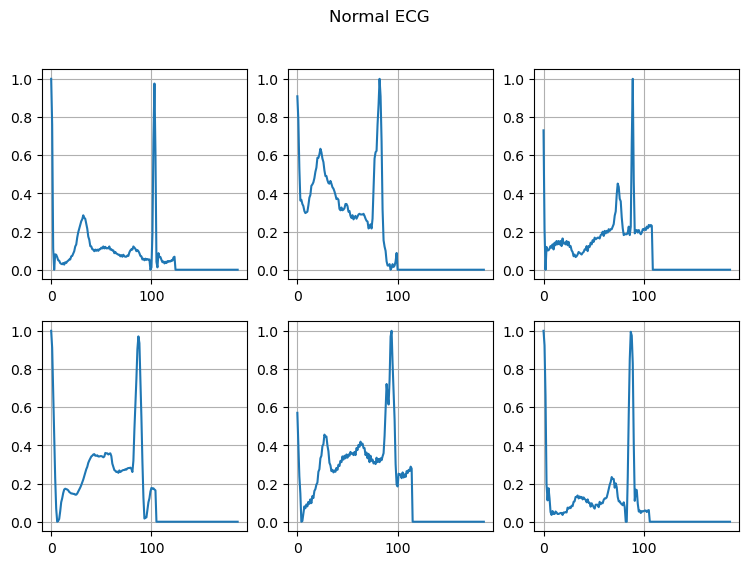

In [15]:
normal_X_test = X_test[Y_test == 0]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(9,6))
fig.suptitle("Normal ECG")
ax = ax.ravel()
for idx, ax in enumerate(ax):
    ax.grid()
    ax.plot(np.arange(len(normal_X_test[idx])), normal_X_test[idx])
plt.show()

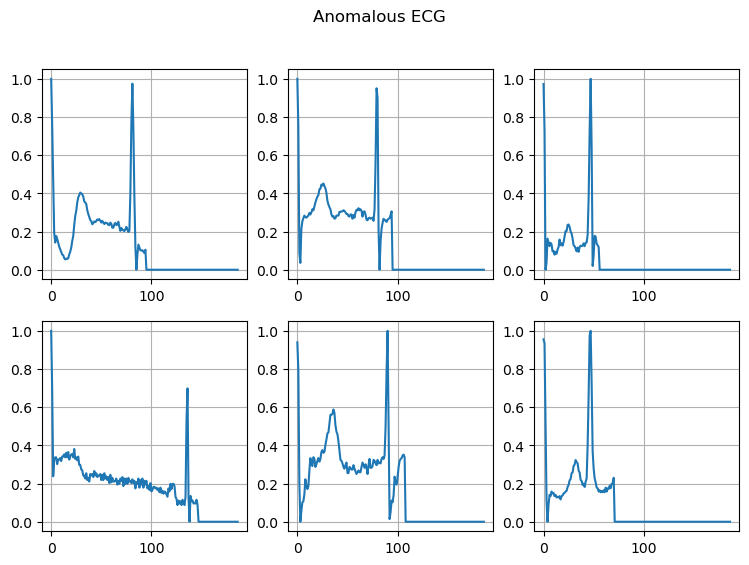

In [16]:
anomalous_X_test = X_test[Y_test!=0]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(9,6))
fig.suptitle("Anomalous ECG")
ax = ax.ravel()
for idx, ax in enumerate(ax):
    ax.grid()
    ax.plot(np.arange(len(anomalous_X_test[idx])), anomalous_X_test[idx])
plt.show()

test_acc = evalute(model, test_loader, criterion)
print('test acc:', test_acc)

In [17]:
batch_size = 1000
iteration = 10
criterion = nn.CrossEntropyLoss()

In [18]:
starter = torch.cuda.Event(enable_timing=True)
ender = torch.cuda.Event(enable_timing=True)
timings=np.zeros((iteration,1))

In [19]:
best_acc, best_epoch = 0, 0
test_acc=[]
test_loss=[]
with torch.no_grad(): # Gradient 연산 비활성화
    for _ in range(iteration):
        starter.record()
        
        correct = 0
        total = 0
    
        test_bar = tqdm(test_loader, file=sys.stdout)
        for step, (x, y) in enumerate(test_bar):
            x, y = x.to(device), y.to(device)
            logits_test = model(x)
            loss = criterion(logits_test, y)
            preds = logits_test.argmax(dim=1)
            correct += torch.eq(preds, y).sum().item()
            total += y.size(0)
            
            test_bar.desc = "test iteration[{}/{}] loss:{:.3f}".format(_ + 1,
                                                                     iteration,
                                                                     loss)
        
        accuracy = correct / total
        test_acc.append(accuracy)  # append를 사용하여 정확도를 리스트에 추가
        
        ender.record()
        torch.cuda.synchronize() # Gpu 연산이 완료될 때까지 대기

average_acc = sum(test_acc) / iteration  # sum 함수와 iteration으로 나누어 평균 계산
print(f"Average Test Accuracy: {average_acc * 100:.2f}%")

infer_time = starter.elapsed_time(ender)
print("Elapsed time: {} s".format(infer_time * 1e-3)) # milliseconds to second

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Average Test Accuracy: 98.57%
Elapsed time: 0.2869037780761719 s


# Record

In [20]:
results = [train_acc, train_loss, val_acc, val_loss]
for i in range(len(results[1])):  # Assuming results[1] refers to train_loss
    results[1][i] = results[1][i].item()
for i in range(len(results[3])):
    results[3][i]=results[3][i].item()

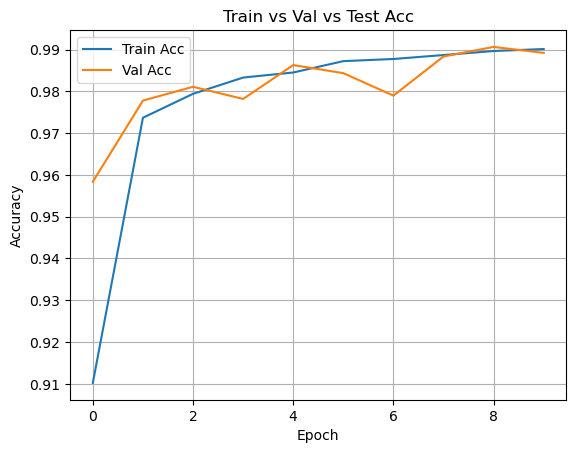

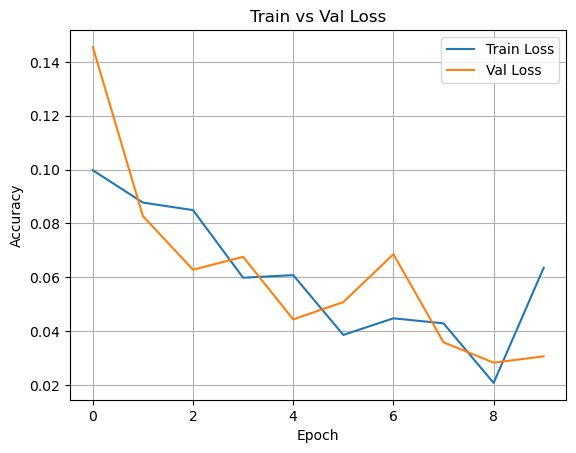

In [21]:
plt.plot(results[0])
plt.plot(results[2])
plt.legend(['Train Acc', 'Val Acc', 'Test Acc'])
plt.title('Train vs Val vs Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()
plt.plot(results[1])
plt.plot(results[3])
plt.legend(['Train Loss', 'Val Loss'])
plt.title('Train vs Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [22]:
print(model)

proposed(
  (conv_in): Conv1d(1, 32, kernel_size=(5,), stride=(1,))
  (conv_blocks): ModuleList(
    (0-4): 5 x ConvBlock(
      (intro_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (C11): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
      (A11): ReLU()
      (C12): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
      (A12): ReLU()
      (M11): MaxPool1d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (avg_pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (fc1): Linear(in_features=32, out_features=32, bias=True)
  (acc1): ReLU()
  (fc2): Linear(in_features=32, out_features=5, bias=True)
)


In [23]:
summary(model, input_size=(1, 187))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 183]             192
       BatchNorm1d-2              [-1, 32, 183]              64
            Conv1d-3              [-1, 32, 183]           5,152
              ReLU-4              [-1, 32, 183]               0
            Conv1d-5              [-1, 32, 183]           5,152
              ReLU-6              [-1, 32, 183]               0
         MaxPool1d-7               [-1, 32, 90]               0
         ConvBlock-8               [-1, 32, 90]               0
       BatchNorm1d-9               [-1, 32, 90]              64
           Conv1d-10               [-1, 32, 90]           5,152
             ReLU-11               [-1, 32, 90]               0
           Conv1d-12               [-1, 32, 90]           5,152
             ReLU-13               [-1, 32, 90]               0
        MaxPool1d-14               [-1,

In [24]:
print(os.system('dot -V'))

0


dot - graphviz version 2.50.0 (0)


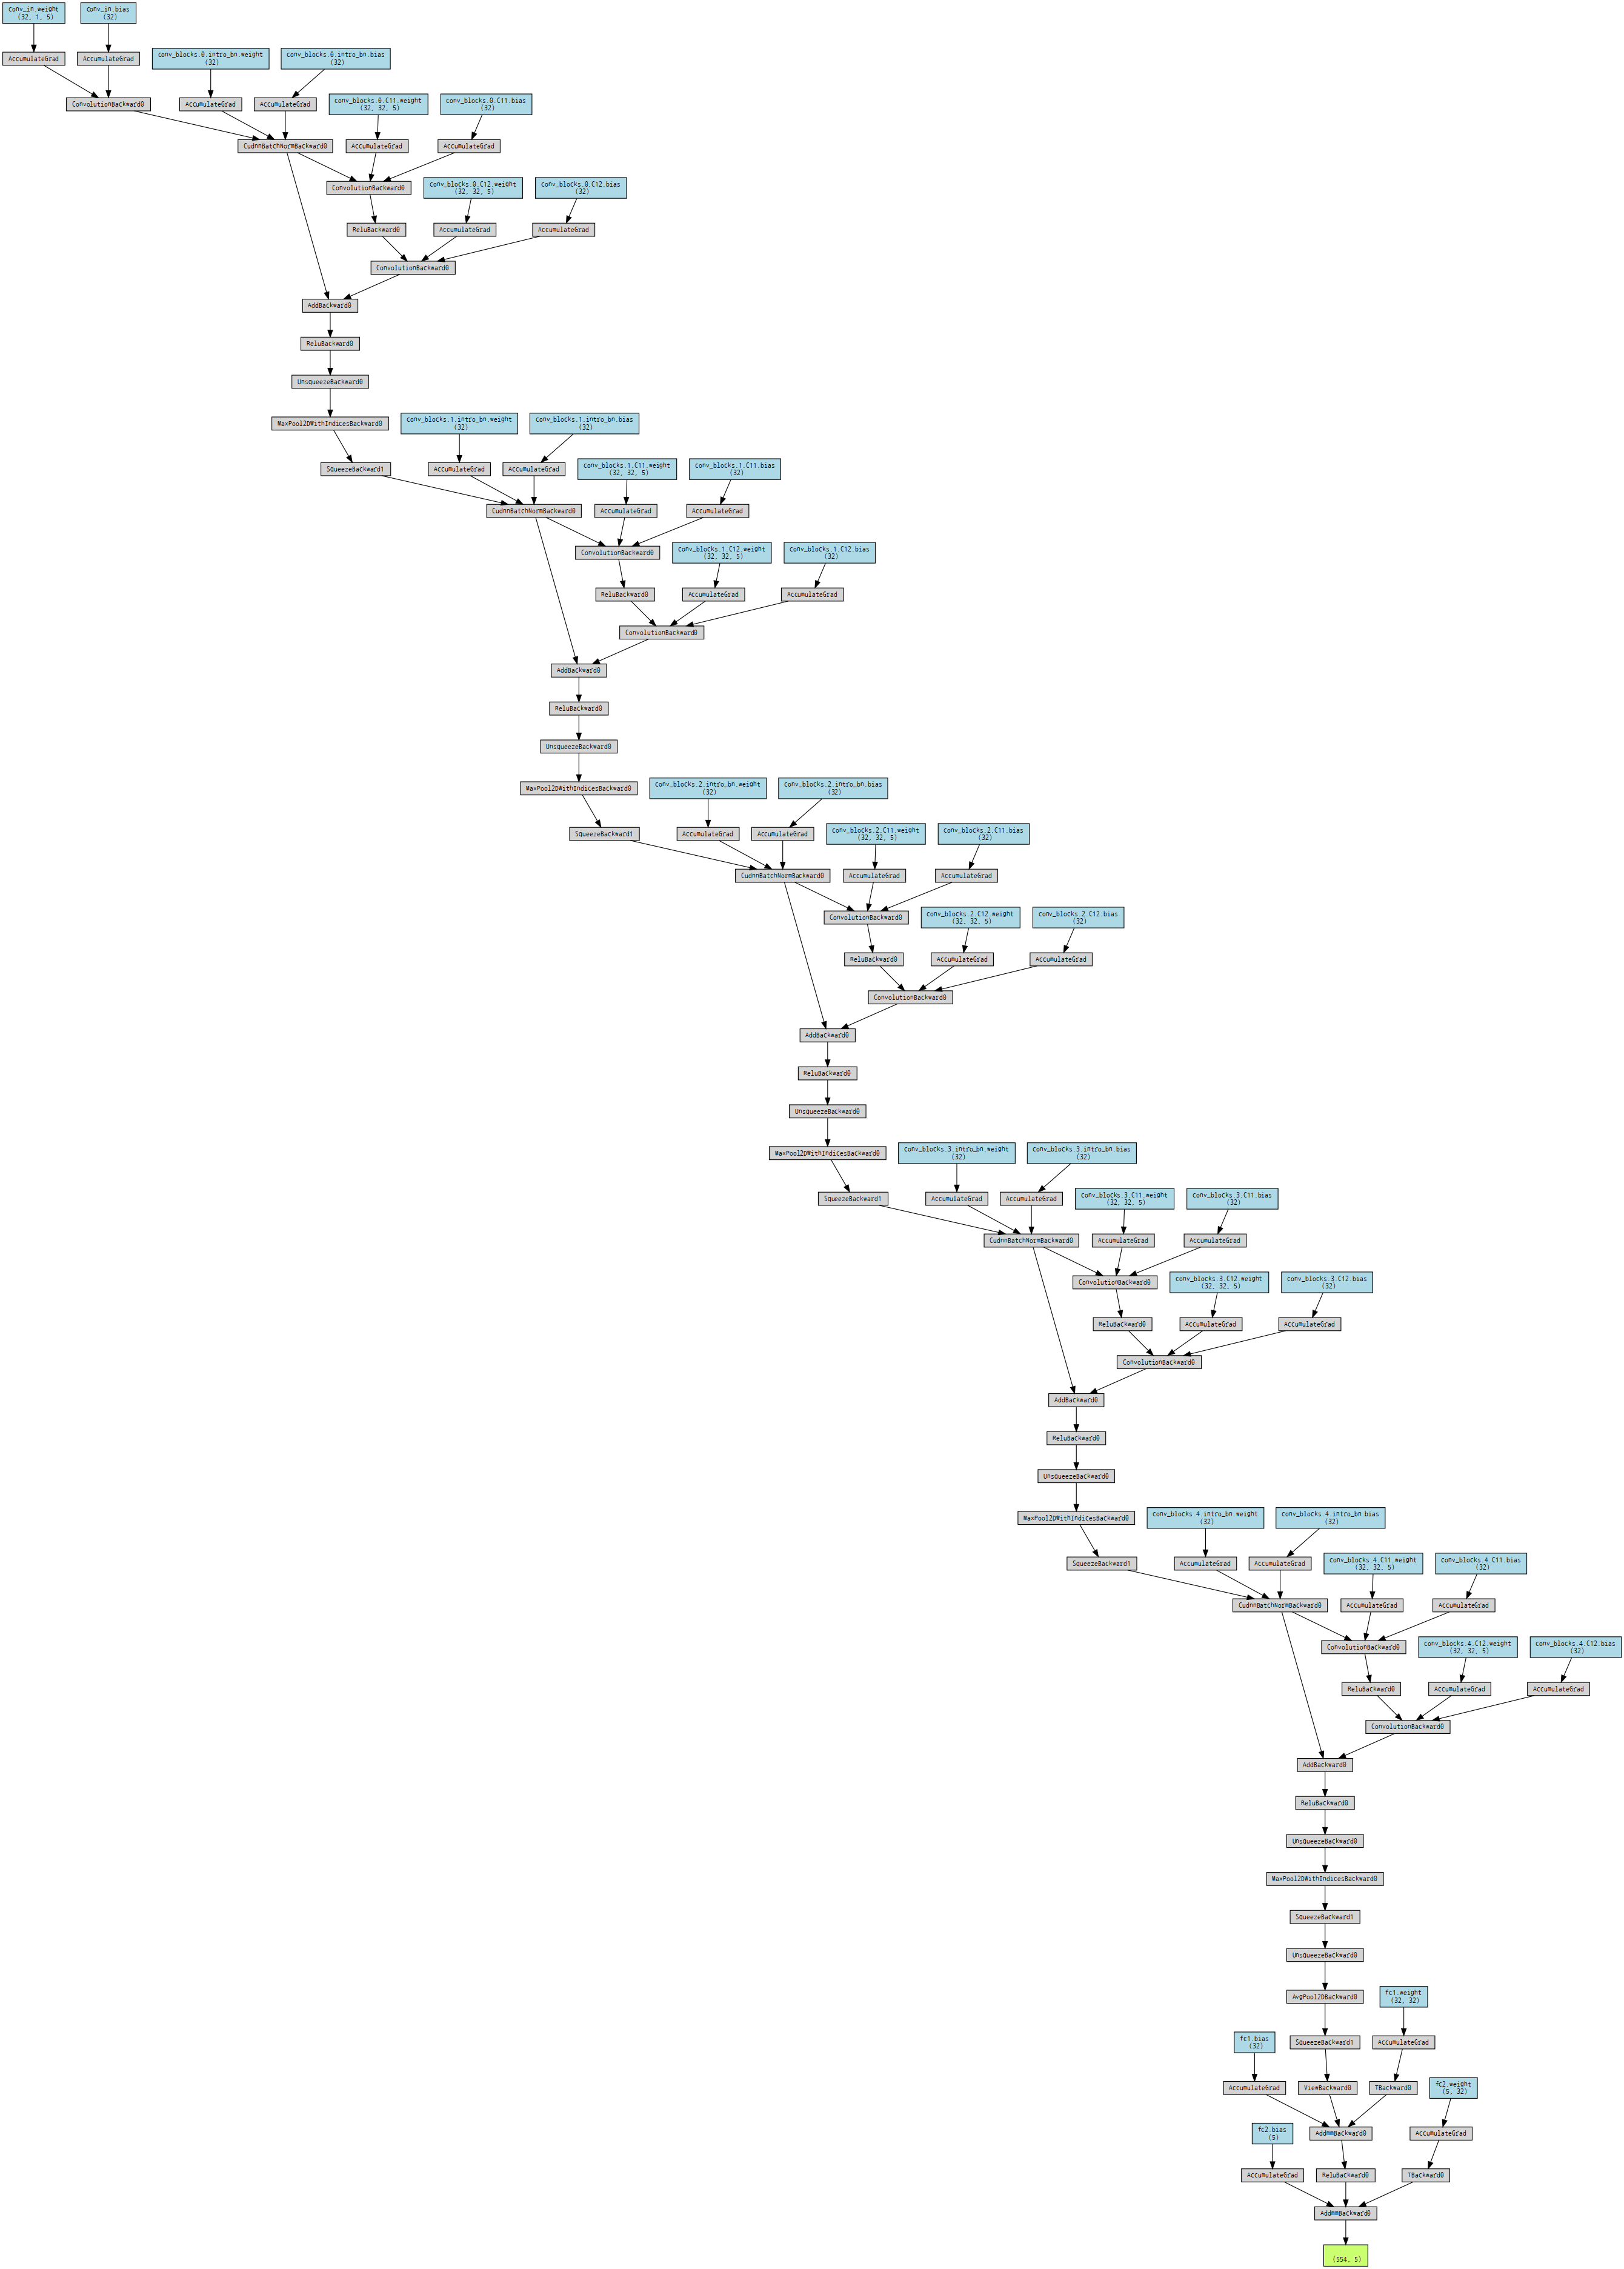

In [25]:
make_dot(logits, params=dict(list(model.named_parameters()))).render("LSTM", format="png")
Image(filename='LSTM.png')

In [26]:
for name, child in model.named_children():
    for param in child.parameters():
        print(name, param)

conv_in Parameter containing:
tensor([[[ 0.3605, -0.1904,  0.1099, -0.0425, -0.4263]],

        [[ 0.3338, -0.0061, -0.3047, -0.2187,  0.0300]],

        [[ 0.2076, -0.1121, -0.0900,  0.3113,  0.3696]],

        [[-0.3644,  0.0441,  0.3740,  0.3388,  0.1272]],

        [[-0.2466,  0.3517,  0.1070, -0.2719,  0.0065]],

        [[ 0.4234, -0.3753,  0.3005, -0.0539, -0.2740]],

        [[ 0.1007, -0.1081, -0.0428, -0.1068, -0.5408]],

        [[ 0.3577, -0.3889,  0.1693, -0.4463,  0.3502]],

        [[-0.0701, -0.1148, -0.2201, -0.4220, -0.3367]],

        [[-0.0716,  0.0879, -0.1791,  0.0258, -0.5269]],

        [[ 0.2424, -0.3699,  0.2862,  0.0603, -0.2316]],

        [[-0.3755, -0.2366,  0.0424, -0.1757, -0.1968]],

        [[ 0.3323,  0.3587,  0.4926,  0.2794,  0.3957]],

        [[-0.0237, -0.2015, -0.3279, -0.1939, -0.4677]],

        [[ 0.2109, -0.0173,  0.1281, -0.2903, -0.1472]],

        [[ 0.2825,  0.3237,  0.1925, -0.2998,  0.1012]],

        [[-0.1939, -0.0841, -0.0360, -0.32